In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets import fetch_openml

# load mnist data
mnist_data = fetch_openml('mnist_784')
X_data = mnist_data.data


In [ ]:
Y_data = mnist_data.target.astype('int32')
shuffle_mask = np.arange(X_data.shape[0])
np.random.shuffle(shuffle_mask)
X_data = X_data[shuffle_mask]
Y_data = Y_data[shuffle_mask]

X_train = X_data[:10000]
X_test = X_data[10000:11000]
Y_train = Y_data[:10000]
Y_test = Y_data[10000:11000]

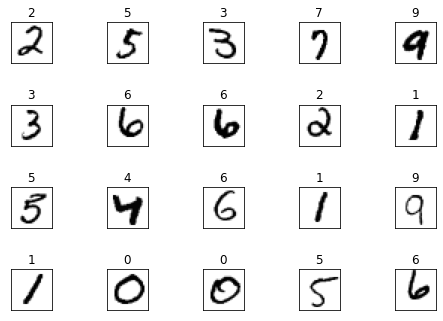

In [ ]:
sample_X = X_train[:20]
sample_Y = Y_train[:20]

fig = plt.figure()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=1, hspace=1)
for i in range(20):
    subplot = fig.add_subplot(4, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d'%sample_Y[i])
    subplot.imshow(sample_X[i].reshape(28,28), cmap=plt.cm.gray_r)
plt.show()

In [ ]:
def Problem_1(X_test, X_train):
    
    test_num = X_test.shape[0]
    train_num = X_train.shape[0]
    dist_mat = np.zeros((test_num, train_num))
    for i in range(test_num):
        for j in range(train_num):
            sub = np.subtract(X_test[i],X_train[j])
            square = np.square(sub)
            dist_mat[i,j] = np.sqrt(np.sum(square))
    dist_mat = np.divide(dist_mat,255)
    return dist_mat


In [ ]:
def Problem_2(X_test, X_train):
    
    test_num = X_test.shape[0]
    train_num = X_train.shape[0]
    dist_mat = np.zeros((test_num, train_num))
    dist_mat = np.divide(np.sqrt(np.tile(np.sum(np.square(X_train), axis=1), (test_num, 1)) + np.tile(np.sum(np.square(X_test), axis=1), (train_num, 1)).T - 2 * np.dot(X_test, X_train.T)),255)
    return dist_mat


In [ ]:
import time

problem1_time = time.time()     
dist_mat_two_loop = Problem_1(X_test,X_train)
problem1_time = time.time()-problem1_time       
problem2_time = time.time()
dist_mat_no_loop = Problem_2(X_test,X_train)
problem2_time = time.time()-problem2_time


print('Problem1 (two for loop) execution time : %f'%problem1_time)
print('Problem2 (no for loop) execution time : %f'%problem2_time)

difference = np.linalg.norm(dist_mat_two_loop - dist_mat_no_loop, ord='fro')
if difference < 0.001:
    print('The distance matrices are the same')
else:
    print('The distance matrices are different')

Problem1 (two for loop) execution time : 113.786144
Problem2 (no for loop) execution time : 0.704440
The distance matrices are the same


In [ ]:
def Problem_4(dist_mat, k, Y_train):
    
    test_num = dist_mat.shape[0]
    Y_predict = np.zeros(test_num)
    
    
    distIdx = np.argsort(dist_mat)
    for i in range(test_num):
        labels = Y_train[distIdx[i,0:k]]
        (values,counts) = np.unique(labels,return_counts=True)
        Y_predict[i] = values[np.argmax(counts)]
    return Y_predict

y_pred = Problem_4(dist_mat_no_loop, 3, Y_train)
accuracy = None
cnt=0
for i in range(y_pred.shape[0]):
    if y_pred[i] == Y_test[i]:
        cnt = cnt + 1
accuracy = 100.*cnt/y_pred.shape[0]
print('Test data prediction accuracy : %f'%accuracy)

Test data prediction accuracy : 94.800000


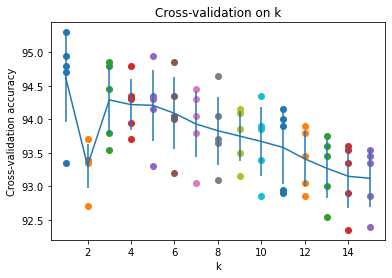

In [ ]:
num_fold = 5
k_candidate = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
accuracy_dict = {}
X_train_folds = []
Y_train_folds = []
for k in k_candidate:
    accuracy_dict[k] = []
for i in range(num_fold):
    test= []
    testStart = i*X_train.shape[0]//num_fold
    testEnd = (i+1)*X_train.shape[0]//num_fold
    test = X_train[testStart:testEnd]
    
    train = []
    trainStart = X_train[:testStart]
    trainEnd = X_train[testEnd:]
    train = np.concatenate([trainStart,trainEnd])
    X_train_folds = Problem_2(test,train)
    yTrain = []
    yTrainStart = Y_train[:testStart]
    yTrainEnd= Y_train[testEnd:]
    yTrain = np.concatenate([yTrainStart,yTrainEnd])
    Y_train_folds = yTrain

    yTest = Y_train[testStart:testEnd]
    for k in k_candidate:
        Y_train_pred = Problem_4(X_train_folds, k, Y_train_folds)
        cnt=0
        for i in range(Y_train_pred.shape[0]):
            if Y_train_pred[i] == yTest[i]:
                cnt = cnt + 1
        accuracy_dict[k].append(100.*cnt/Y_train_pred.shape[0])
        
for k in k_candidate:
    accuracies = accuracy_dict[k]
    plt.scatter([k] * len(accuracies), accuracies)
    
accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracy_dict.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(accuracy_dict.items())])
plt.errorbar(k_candidate, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
best_k = np.argmax(accuracies_mean)+1

y_pred = Problem_4(dist_mat_no_loop, best_k, Y_train)
accuracy = None
cnt=0
for i in range(y_pred.shape[0]):
    if y_pred[i] == Y_test[i]:
        cnt = cnt + 1
accuracy = 100.*cnt/y_pred.shape[0] 
print('Test data prediction accuracy : %f'%accuracy)

Test data prediction accuracy : 94.800000


1
[0.9515 0.9325 0.947  0.947  0.95  ]
2
[0.937  0.9235 0.9335 0.935  0.935 ]
3
[0.9475 0.934  0.938  0.944  0.949 ]


ValueError: ignored

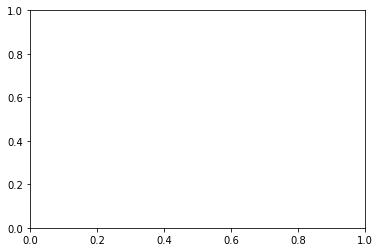

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_candidate = [1,2,3]
accuracy_dict = {}
for k in k_candidate:
    accuracy_dict[k] = []

for k in k_candidate:
    knn = KNeighborsClassifier(n_neighbors=k)
    print(k)
    scores = cross_val_score(knn,X_train,Y_train,cv=5)
    print(scores)
    accuracy_dict[k].append(scores)


for k in k_candidate:
    accuracies = accuracy_dict[k]
    plt.scatter([k] * len(accuracies), accuracies)
    
accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracy_dict.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(accuracy_dict.items())])
plt.errorbar(k_candidate, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
best_k = np.argmax(accuracies_mean)+1
knn = KNeighborsClassifier(best_k)
knn.fit(X_train,Y_train)
y_pred = None
accuracy = None
accuracy = knn.score(X_test,Y_test)
print('Test data prediction accuracy : %f'%accuracy)